In [1]:
import numpy as np
from numpy import matlib as ml
import pandas as pd
import os
import warnings
import librosa
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle
import scipy.stats as st

from pynwb import NWBHDF5IO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

import pdb
# warnings.filterwarnings('ignore')

In [2]:
# ----- LOAD DATA -----
data = pd.read_csv('all_annotations.csv')

# ----- FIGURES -----
outp = os.path.join('figures','2025January')

# ----- SET UP COLORS -----
acols = [[0.627451,   0.57254905, 0.37254903],
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2]
mcols = acols[2:]

fpal = sns.color_palette(fcols)
mpal = sns.color_palette(mcols)
apal = sns.color_palette(acols)

# set hue order
ho = ['WT','Het']

In [32]:
# ----- FILTER DATA TO MALE STRANGER REJECTIONS AND SEPARATION REUNIONS -----

filtdat = data[np.logical_or(data.assay=='aggression',data.assay=='reunion')]

In [6]:
filtdat.head()

,Unnamed: 0,id,start_time,stop_time,behavior,duration,atype,pair_tag,sex,GT,color,assay,pair_num
5033,5033,1,0.001,10.454,No interaction,10.453,STATE,Pair17,M,Het,[ 63. 78. 245.],aggression,0
5034,5034,2,10.455,11.901,Investigate,1.446,STATE,Pair17,M,Het,[ 63. 78. 245.],aggression,0
5035,5035,3,11.902,12.403,No interaction,0.501,STATE,Pair17,M,Het,[ 63. 78. 245.],aggression,0
5036,5036,4,12.404,14.454,Investigate,2.050,STATE,Pair17,M,Het,[ 63. 78. 245.],aggression,0
5037,5037,5,14.455,14.899,No interaction,0.444,STATE,Pair17,M,Het,[ 63. 78. 245.],aggression,0


In [33]:
# ----- FIND TIME OF FIRST HUDDLE -----

filtdat['first_huddle'] = filtdat[filtdat.behavior=='Huddle'].groupby(['pair_tag','assay'])['start_time'].transform('min')
filtdat['first_huddle_all'] = filtdat.groupby(['pair_tag','assay'])['first_huddle'].transform(lambda x: np.unique(x)[0])

C:\Users\nhogl\AppData\Local\Temp\ipykernel_4588\2853809395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtdat['first_huddle'] = filtdat[filtdat.behavior=='Huddle'].groupby(['pair_tag','assay'])['start_time'].transform('min')
C:\Users\nhogl\AppData\Local\Temp\ipykernel_4588\2853809395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtdat['first_huddle_all'] = filtdat.groupby(['pair_tag','assay'])['first_huddle'].transform(lambda x: np.unique(x)[0])


In [82]:
# ----- CALCULATE TOTAL HUDDLE TIME FOR COMPARISON TO OTHER METRICS -----
filtdat['total_huddle'] = filtdat[filtdat.behavior=='Huddle'].groupby(['pair_tag','assay'])['duration'].transform('sum')
filtdat['total_huddle_all'] = filtdat.groupby(['pair_tag','assay'])['total_huddle'].transform(lambda x: np.unique(x)[0])

C:\Users\nhogl\AppData\Local\Temp\ipykernel_4588\3293293753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtdat['total_huddle'] = filtdat[filtdat.behavior=='Huddle'].groupby(['pair_tag','assay'])['duration'].transform('sum')
C:\Users\nhogl\AppData\Local\Temp\ipykernel_4588\3293293753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtdat['total_huddle_all'] = filtdat.groupby(['pair_tag','assay'])['total_huddle'].transform(lambda x: np.unique(x)[0])


In [85]:
# ----- FIND SNIFFS BEFORE FIRST HUDDLE -----

sniffs = filtdat[filtdat.behavior=='Sniff']
sniffs['use_sniffs'] = sniffs.start_time<sniffs.first_huddle_all

C:\Users\nhogl\AppData\Local\Temp\ipykernel_4588\436355632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sniffs['use_sniffs'] = sniffs.start_time<sniffs.first_huddle_all


In [86]:
# ----- DO COUNTS -----
counts = sniffs[sniffs.use_sniffs==True].groupby(['pair_tag','assay','GT','sex','first_huddle_all','total_huddle_all'])['start_time'].count().reset_index(name='counts')

In [87]:
counts

,pair_tag,assay,GT,sex,first_huddle_all,total_huddle_all,counts
0,Pair15,aggression,Het,F,89.248,47.033,13
1,Pair15,reunion,Het,F,13.656,669.495,9
2,Pair16,reunion,WT,F,14.414,961.173,5
3,Pair17,reunion,Het,M,16.826,226.578,3
4,Pair18,aggression,WT,M,39.744,56.692,8
...,...,...,...,...,...,...,...
63,Pair62,aggression,WT,F,70.335,9.251,6
64,Pair62,reunion,WT,F,16.166,581.122,5
65,Pair7,aggression,Het,F,34.007,7.695,9
66,Pair7,reunion,Het,F,8.991,1132.272,1


count, male, reunion:
MannwhitneyuResult(statistic=67.0, pvalue=0.9753223600426162)
count, male, aggression:
MannwhitneyuResult(statistic=45.0, pvalue=0.16152975271529268)


Text(0.5, 1.0, 'Sniffs before first huddle, aggression, males')

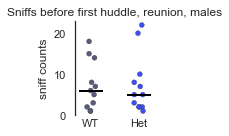

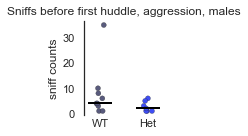

In [90]:
# ----- PLOT MALE COUNTS -----
sz=5 # dot size for strip plots
alpha=1 # dot transparency for strip plots
medianwidth=0.5 # width on x axis of median bands
mw = medianwidth/2 # convert to halfwidth for plotting
lw = 2 # weight of median band lines
hue_order = ['WT','Het'] # how groups should be arranged on x axis
csz = 0.25
ptc='k'
plw=0.25
zorder=5
nrows = 2
ncols = 4
sns.set_theme(style='white')

rcounts = counts[counts.assay=='reunion']

count_M_reu = st.mannwhitneyu(rcounts.counts[np.logical_and(rcounts.sex=='M',rcounts.GT=='WT')].dropna(),
                              rcounts.counts[np.logical_and(rcounts.sex=='M',rcounts.GT=='Het')].dropna())
print('count, male, reunion:')
print(count_M_reu)


f, ax = plt.subplots(1,1,figsize=(2, 2))
f.tight_layout()

strip_plots_with_medians(counts[counts.assay=='reunion'],'M','counts','GT',sz,alpha,ptc,plw,mpal,
                         hue_order,mw,zorder,'sniff counts',ax,f)
ax.set_title('Sniffs before first huddle, reunion, males')

acounts = counts[counts.assay=='aggression']

count_M_agg = st.mannwhitneyu(acounts.counts[np.logical_and(acounts.sex=='M',acounts.GT=='WT')].dropna(),
                              acounts.counts[np.logical_and(acounts.sex=='M',acounts.GT=='Het')].dropna())
print('count, male, aggression:')
print(count_M_agg)

g,ax2 = plt.subplots(1,1,figsize=(2, 2))
g.tight_layout()

strip_plots_with_medians(counts[counts.assay=='aggression'],'M','counts','GT',sz,alpha,ptc,plw,mpal,
                         hue_order,mw,zorder,'sniff counts',ax2,g)
ax2.set_title('Sniffs before first huddle, aggression, males')

Text(0.5, 0, 'total time huddling (s)')

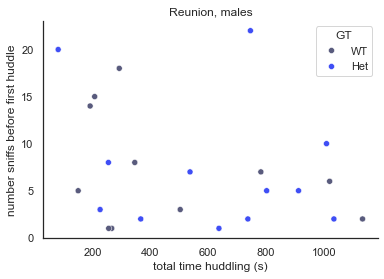

In [98]:
ax = sns.scatterplot(rcounts[rcounts.sex=='M'],x='total_huddle_all',y='counts',hue='GT',palette=mpal,hue_order=ho)
sns.despine(ax=ax)
ax.set_title('Reunion, males')
ax.set_ylabel('number sniffs before first huddle')
ax.set_xlabel('total time huddling (s)')

Text(0.5, 0, 'latency to first huddle (s)')

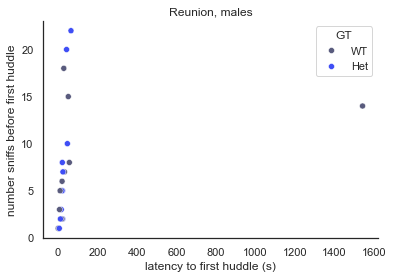

In [103]:
ax = sns.scatterplot(rcounts[rcounts.sex=='M'],x='first_huddle_all',y='counts',hue='GT',palette=mpal,hue_order=ho)
sns.despine(ax=ax)
ax.set_title('Reunion, males')
ax.set_ylabel('number sniffs before first huddle')
ax.set_xlabel('latency to first huddle (s)')

Text(0.5, 0, 'total time huddling (s)')

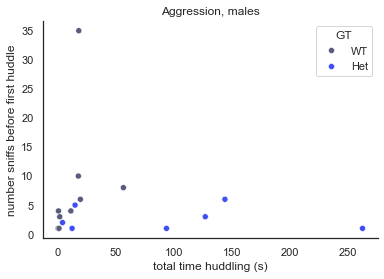

In [101]:
ax = sns.scatterplot(acounts[acounts.sex=='M'],x='total_huddle_all',y='counts',hue='GT',palette=mpal,hue_order=ho)
sns.despine(ax=ax)
ax.set_title('Aggression, males')
ax.set_ylabel('number sniffs before first huddle')
ax.set_xlabel('total time huddling (s)')

Text(0.5, 0, 'latency to first huddle (s)')

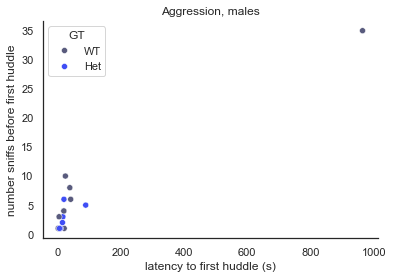

In [105]:
ax = sns.scatterplot(acounts[acounts.sex=='M'],x='first_huddle_all',y='counts',hue='GT',palette=mpal,hue_order=ho)
sns.despine(ax=ax)
ax.set_title('Aggression, males')
ax.set_ylabel('number sniffs before first huddle')
ax.set_xlabel('latency to first huddle (s)')

Text(0.5, 0, 'total time huddling (s)')

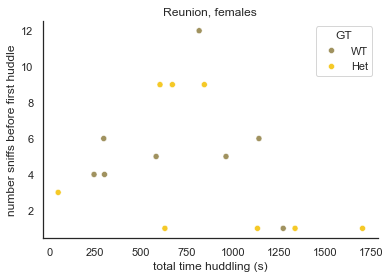

In [99]:
ax = sns.scatterplot(rcounts[rcounts.sex=='F'],x='total_huddle_all',y='counts',hue='GT',palette=fpal,hue_order=ho)
sns.despine(ax=ax2)
ax.set_title('Reunion, females')
ax.set_ylabel('number sniffs before first huddle')
ax.set_xlabel('total time huddling (s)')

Text(0.5, 0, 'total time huddling (s)')

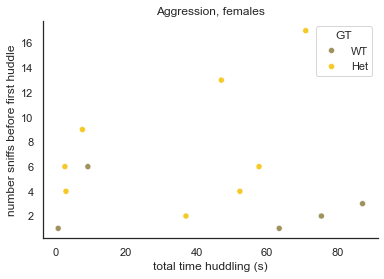

In [102]:
ax = sns.scatterplot(acounts[acounts.sex=='F'],x='total_huddle_all',y='counts',hue='GT',palette=fpal,hue_order=ho)
sns.despine(ax=ax)
ax.set_title('Aggression, females')
ax.set_ylabel('number sniffs before first huddle')
ax.set_xlabel('total time huddling (s)')

Text(0.5, 0, 'latency to first huddle (s)')

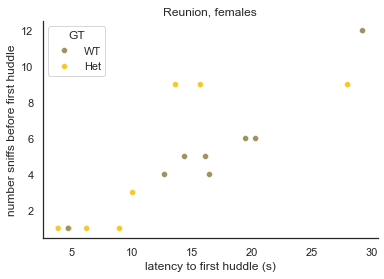

In [106]:
ax = sns.scatterplot(rcounts[rcounts.sex=='F'],x='first_huddle_all',y='counts',hue='GT',palette=fpal,hue_order=ho)
sns.despine(ax=ax)
ax.set_title('Reunion, females')
ax.set_ylabel('number sniffs before first huddle')
ax.set_xlabel('latency to first huddle (s)')

Text(0.5, 0, 'latency to first huddle (s)')

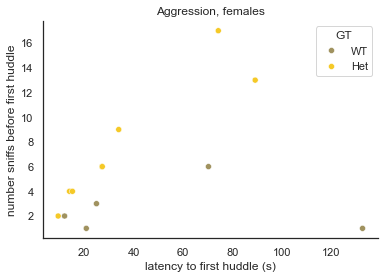

In [107]:
ax = sns.scatterplot(acounts[acounts.sex=='F'],x='first_huddle_all',y='counts',hue='GT',palette=fpal,hue_order=ho)
sns.despine(ax=ax)
ax.set_title('Aggression, females')
ax.set_ylabel('number sniffs before first huddle')
ax.set_xlabel('latency to first huddle (s)')

count, female, reunion:
MannwhitneyuResult(statistic=40.0, pvalue=0.42152606412575266)
count, female, aggression:
MannwhitneyuResult(statistic=5.5, pvalue=0.03851000325807623)


Text(0.5, 1.0, 'Sniffs before first huddle, aggression, females')

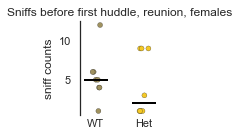

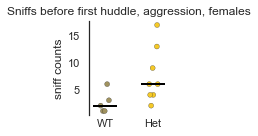

In [74]:
# ----- PLOT FEMALE COUNTS -----
sz=5 # dot size for strip plots
alpha=1 # dot transparency for strip plots
medianwidth=0.5 # width on x axis of median bands
mw = medianwidth/2 # convert to halfwidth for plotting
lw = 2 # weight of median band lines
hue_order = ['WT','Het'] # how groups should be arranged on x axis
csz = 0.25
ptc='k'
plw=0.25
zorder=5
nrows = 2
ncols = 4
sns.set_theme(style='white')
f, ax = plt.subplots(1,1,figsize=(2, 2))
f.tight_layout()


count_F_reu = st.mannwhitneyu(rcounts.counts[np.logical_and(rcounts.sex=='F',rcounts.GT=='WT')].dropna(),
                              rcounts.counts[np.logical_and(rcounts.sex=='F',rcounts.GT=='Het')].dropna())
print('count, female, reunion:')
print(count_F_reu)

strip_plots_with_medians(counts[counts.assay=='reunion'],'F','counts','GT',sz,alpha,ptc,plw,fpal,
                         hue_order,mw,zorder,'sniff counts',ax,f)
ax.set_title('Sniffs before first huddle, reunion, females')

g,ax2 = plt.subplots(1,1,figsize=(2, 2))
g.tight_layout()

count_F_agg = st.mannwhitneyu(acounts.counts[np.logical_and(acounts.sex=='F',acounts.GT=='WT')].dropna(),
                              acounts.counts[np.logical_and(acounts.sex=='F',acounts.GT=='Het')].dropna())
print('count, female, aggression:')
print(count_F_agg)

strip_plots_with_medians(counts[counts.assay=='aggression'],'F','counts','GT',sz,alpha,ptc,plw,fpal,
                         hue_order,mw,zorder,'sniff counts',ax2,g)
ax2.set_title('Sniffs before first huddle, aggression, females')

In [100]:
# ----- DO TOTALS -----
totals = sniffs[sniffs.use_sniffs==True].groupby(['pair_tag','assay','GT','sex','first_huddle_all','total_huddle_all'])['duration'].sum().reset_index(name='total')

total, male, reunion:
MannwhitneyuResult(statistic=66.0, pvalue=1.0)
total, male, aggression:
MannwhitneyuResult(statistic=42.0, pvalue=0.29912587412587416)


Text(0.5, 1.0, 'Sniffs before first huddle, aggression, males')

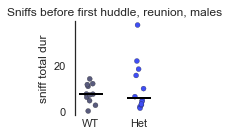

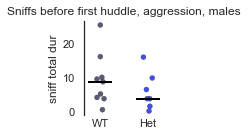

In [110]:
# ----- PLOT MALE TOTALS -----
sz=5 # dot size for strip plots
alpha=1 # dot transparency for strip plots
medianwidth=0.5 # width on x axis of median bands
mw = medianwidth/2 # convert to halfwidth for plotting
lw = 2 # weight of median band lines
hue_order = ['WT','Het'] # how groups should be arranged on x axis
csz = 0.25
ptc='k'
plw=0.25
zorder=5
nrows = 2
ncols = 4
sns.set_theme(style='white')
f, ax = plt.subplots(1,1,figsize=(2, 2))
f.tight_layout()

rtotals = totals[totals.assay=='reunion']

total_M_reu = st.mannwhitneyu(rtotals.total[np.logical_and(rtotals.sex=='M',rtotals.GT=='WT')].dropna(),
                              rtotals.total[np.logical_and(rtotals.sex=='M',rtotals.GT=='Het')].dropna())
print('total, male, reunion:')
print(total_M_reu)

strip_plots_with_medians(totals[totals.assay=='reunion'],'M','total','GT',sz,alpha,ptc,plw,mpal,
                         hue_order,mw,zorder,'sniff total dur',ax,f)
ax.set_title('Sniffs before first huddle, reunion, males')

g,ax2 = plt.subplots(1,1,figsize=(2, 2))
g.tight_layout()

atotals = totals[totals.assay=='aggression']

total_M_agg = st.mannwhitneyu(atotals.total[np.logical_and(atotals.sex=='M',atotals.GT=='WT')].dropna(),
                              atotals.total[np.logical_and(atotals.sex=='M',atotals.GT=='Het')].dropna())
print('total, male, aggression:')
print(total_M_agg)


strip_plots_with_medians(totals[totals.assay=='aggression'],'M','total','GT',sz,alpha,ptc,plw,mpal,
                         hue_order,mw,zorder,'sniff total dur',ax2,g)
ax2.set_title('Sniffs before first huddle, aggression, males')

Text(0.5, 0, 'total time huddling (s)')

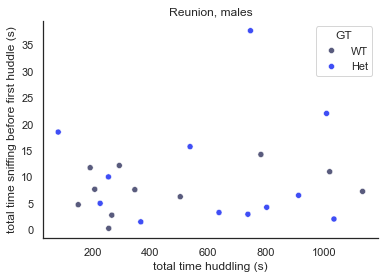

In [111]:
ax = sns.scatterplot(rtotals[rtotals.sex=='M'],x='total_huddle_all',y='total',hue='GT',palette=mpal,hue_order=ho)
sns.despine(ax=ax)
ax.set_title('Reunion, males')
ax.set_ylabel('total time sniffing before first huddle (s)')
ax.set_xlabel('total time huddling (s)')

Text(0.5, 0, 'total time huddling (s)')

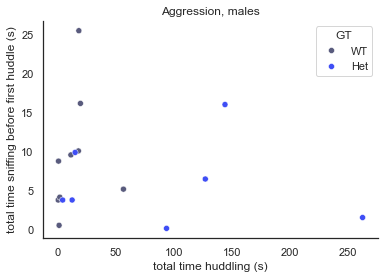

In [112]:
ax = sns.scatterplot(atotals[atotals.sex=='M'],x='total_huddle_all',y='total',hue='GT',palette=mpal,hue_order=ho)
sns.despine(ax=ax)
ax.set_title('Aggression, males')
ax.set_ylabel('total time sniffing before first huddle (s)')
ax.set_xlabel('total time huddling (s)')

Text(0.5, 0, 'total time huddling (s)')

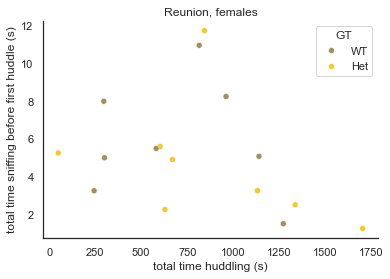

In [113]:
ax = sns.scatterplot(rtotals[rtotals.sex=='F'],x='total_huddle_all',y='total',hue='GT',palette=fpal,hue_order=ho)
sns.despine(ax=ax)
ax.set_title('Reunion, females')
ax.set_ylabel('total time sniffing before first huddle (s)')
ax.set_xlabel('total time huddling (s)')

Text(0.5, 0, 'total time huddling (s)')

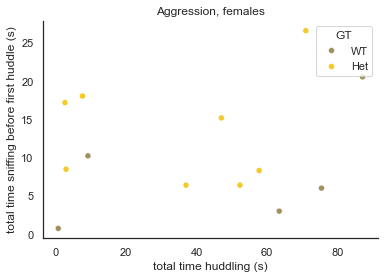

In [114]:
ax = sns.scatterplot(atotals[atotals.sex=='F'],x='total_huddle_all',y='total',hue='GT',palette=fpal,hue_order=ho)
sns.despine(ax=ax)
ax.set_title('Aggression, females')
ax.set_ylabel('total time sniffing before first huddle (s)')
ax.set_xlabel('total time huddling (s)')

total, female, reunion:
MannwhitneyuResult(statistic=41.5, pvalue=0.34420733878501386)
total, female, aggression:
MannwhitneyuResult(statistic=11.0, pvalue=0.2222222222222222)


Text(0.5, 1.0, 'Sniffs before first huddle, aggression, females')

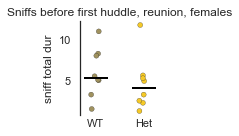

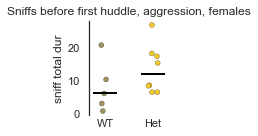

In [79]:
# ----- PLOT FEMALE TOTALS -----
sz=5 # dot size for strip plots
alpha=1 # dot transparency for strip plots
medianwidth=0.5 # width on x axis of median bands
mw = medianwidth/2 # convert to halfwidth for plotting
lw = 2 # weight of median band lines
hue_order = ['WT','Het'] # how groups should be arranged on x axis
csz = 0.25
ptc='k'
plw=0.25
zorder=5
nrows = 2
ncols = 4
sns.set_theme(style='white')
f, ax = plt.subplots(1,1,figsize=(2, 2))
f.tight_layout()

strip_plots_with_medians(totals[totals.assay=='reunion'],'F','total','GT',sz,alpha,ptc,plw,fpal,
                         hue_order,mw,zorder,'sniff total dur',ax,f)
ax.set_title('Sniffs before first huddle, reunion, females')

total_F_reu = st.mannwhitneyu(rtotals.total[np.logical_and(rtotals.sex=='F',rtotals.GT=='WT')].dropna(),
                              rtotals.total[np.logical_and(rtotals.sex=='F',rtotals.GT=='Het')].dropna())
print('total, female, reunion:')
print(total_F_reu)

g,ax2 = plt.subplots(1,1,figsize=(2, 2))
g.tight_layout()

total_F_agg = st.mannwhitneyu(atotals.total[np.logical_and(atotals.sex=='F',atotals.GT=='WT')].dropna(),
                              atotals.total[np.logical_and(atotals.sex=='F',atotals.GT=='Het')].dropna())
print('total, female, aggression:')
print(total_F_agg)

strip_plots_with_medians(totals[totals.assay=='aggression'],'F','total','GT',sz,alpha,ptc,plw,fpal,
                         hue_order,mw,zorder,'sniff total dur',ax2,g)
ax2.set_title('Sniffs before first huddle, aggression, females')

In [31]:
def strip_plots_with_medians(datatab,sex,plotvar,huevar,sz,alpha,edgecolor,ptborder,palette,hueorder,mw,zorder,ylabel,ax,f):
    
    spec = dict(x=huevar, y=plotvar, data=datatab[datatab.sex==sex],hue=huevar)
    
    sns.stripplot(**spec,s=sz,
                  alpha=alpha,
                  legend=False,
                  ax=ax,
                  edgecolor=edgecolor,
                  linewidth=ptborder,
                  palette=palette,
                  hue_order=hue_order,
                  order=hue_order)

    medtab = datatab[datatab.sex==sex].groupby(huevar, sort=False)[plotvar].median().reindex(hueorder)
    _ = [ax.hlines(y, i-mw, i+mw, zorder=zorder,colors=[0,0,0],linewidths=lw) for i, y in medtab.reset_index()[plotvar].items()]

    # make axes look nice
    ax.set(xlabel="")
    ax.set(ylabel=ylabel)
    sns.despine(fig=f, ax=ax, top=True, right=True, left=False, bottom=True, offset=None, trim=False)
    ax.tick_params(axis='x',length=0)